<a href="https://colab.research.google.com/github/FlierK254/Dholuo-Swahili-Neural-Machine-Translator/blob/main/MT_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import pandas as pd
# import os
# os.listdir()
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# df = pd.read_csv("/content/drive/MyDrive/en-fr.txt", names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')

# # df = pd.read_csv('Data/en-fr.txt', names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')
# df = df.sample(frac=1, random_state=42)
# df = df.reset_index(drop=True)
# df.head()


In [ ]:
import os
import pandas as pd
os.listdir()
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
df = pd.read_csv("/content/drive/MyDrive/cleaned_data.csv")
df.head()

Mounted at /content/drive


,O,T
0,6AM DALA FM NEWS 9TH MARCH 2021 HEADLINE.,VIDOKEZI VYA HABARI YA SAA KUMI NA MBILI ASUBU...
1,"MIGAWO MA OCHUNG NE WECHE MEDO REMO, KENYA NAT...","WASIMAMIZI WA HUDUMA ZA KUTIWA DAMU MISHAPANI,..."
2,CHIENRONO MA OTISI NI KEEP MOTHERS ALIVE IBIRO...,SHUGHULI YA LINDA UHAI WA WANAWAKE AMBAYO IMEK...
3,ONDAMONO OKAW BANG YANGORE NI ATAMALO 34 MAG M...,HATUA HIYO IMECHUKULIWA BAADA YA ASILIMIA 34 Y...
4,DR. NDUKU KILONZO EN JATEND MIGAWO MA OCHUNG N...,DKT. NDUKU KILONZO NI KIONGOZI ANAYESIMAMIA KU...


In [ ]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

def clean_and_prepare_text(text):
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['O'] = df['O'].apply(lambda row: clean_text(row))
df['T'] = df['T'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,O,T
0,am dala fm news th march headline,[start] vidokezi vya habari ya saa kumi na mbi...
1,migawo ma ochung ne weche medo remo kenya nati...,[start] wasimamizi wa huduma za kutiwa damu mi...
2,chienrono ma otisi ni keep mothers alive ibiro...,[start] shughuli ya linda uhai wa wanawake amb...
3,ondamono okaw bang yangore ni atamalo mag min...,[start] hatua hiyo imechukuliwa baada ya asili...
4,dr nduku kilonzo en jatend migawo ma ochung ne...,[start] dkt nduku kilonzo ni kiongozi anayesim...


In [ ]:
O = df['O']
T = df['O']

en_max_len = max(len(line.split()) for line in O)
fr_max_len = max(len(line.split()) for line in T)
sequence_len = max(en_max_len, fr_max_len)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (English): 210
Max phrase length (French): 210
Sequence length: 210


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(O)
en_sequences = en_tokenizer.texts_to_sequences(O)
en_x = pad_sequences(en_sequences, maxlen=sequence_len, padding='post')

fr_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
fr_tokenizer.fit_on_texts(T)
fr_sequences = fr_tokenizer.texts_to_sequences(T)
fr_y = pad_sequences(fr_sequences, maxlen=sequence_len + 1, padding='post')

In [ ]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')


Vocabulary size (English): 8063
Vocabulary size (French): 8063


In [ ]:
inputs = { 'encoder_input': en_x, 'decoder_input': fr_y[:, :-1] }
outputs = fr_y[:, 1:]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from keras_nlp.layers import TokenAndPositionEmbedding, TransformerEncoder
from keras_nlp.layers import TransformerDecoder

np.random.seed(42)
tf.random.set_seed(42)

num_heads = 8
embed_dim = 256

encoder_input = Input(shape=(None,), dtype='int64', name='encoder_input')
x = TokenAndPositionEmbedding(en_vocab_size, sequence_len, embed_dim)(encoder_input)
encoder_output = TransformerEncoder(embed_dim, num_heads)(x)
encoded_seq_input = Input(shape=(None, embed_dim))

decoder_input = Input(shape=(None,), dtype='int64', name='decoder_input')
x = TokenAndPositionEmbedding(fr_vocab_size, sequence_len, embed_dim, mask_zero=True)(decoder_input)
x = TransformerDecoder(embed_dim, num_heads)(x, encoded_seq_input)
x = Dropout(0.7)(x)

decoder_output = Dense(fr_vocab_size, activation='softmax')(x)
decoder = Model([decoder_input, encoded_seq_input], decoder_output)
decoder_output = decoder([decoder_input, encoder_output])

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=120)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ encoder_input (InputLayer)        │ (None, None)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ token_and_position_embedding_2    │ (None, None, 256)            │         2,117,888 │ encoder_input[0][0]       
│ (TokenAndPositionEmbedding)       │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ decoder_input (InputLayer)        │ (None, None)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ transformer_encoder_1             │ (None, None, 256)            │           395,776 │ token_and_position_embeddi
│ (TransformerEncoder)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ functional_5 (Functional)         │ (None, None, 8063)           │         4,849,535 │ decoder_input[0][0],      
│                                   │                              │                   │ transformer_encoder_1[0][0
└───────────────────────────────────┴──────────────────────────────┴───────────────────┴───────────────────────────

 Total params: 7,363,199 (28.09 MB)

 Trainable params: 7,363,199 (28.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
hist = model.fit(inputs, outputs, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.7761 - loss: 7.0029 - val_accuracy: 0.8997 - val_loss: 6.7406
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.6187 - loss: 6.5056 - val_accuracy: 0.4995 - val_loss: 6.3479
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.4349 - loss: 5.7095 - val_accuracy: 0.4457 - val_loss: 6.1546
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.3652 - loss: 5.0949 - val_accuracy: 0.4963 - val_loss: 6.0869
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.3666 - loss: 4.6304 - val_accuracy: 0.4343 - val_loss: 6.0961
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.3433 - loss: 4.2490 - val_accuracy: 0.2421 - val_loss: 6.2053
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.2981 - loss: 3.9392 - val_accuracy: 0.2252 - val_loss: 6.2421
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.2538 - loss: 3.6830

[]

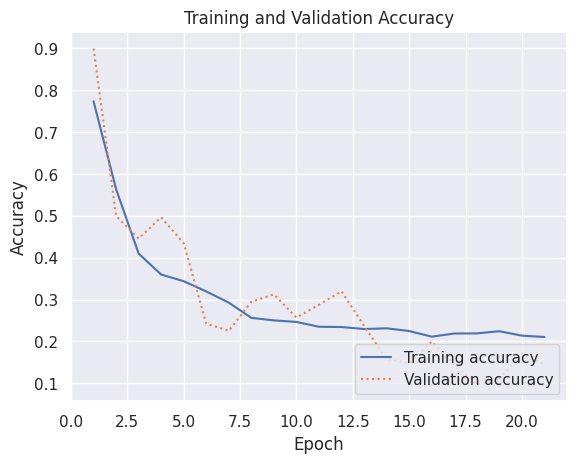

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
translate_text('dala', model, en_tokenizer, fr_tokenizer, fr_index_lookup, sequence_len)

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 209 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

In [ ]:
# import os
# import pandas as pd

# # Define the directory containing the text files
# directory = 'Dholuo'

# # Path for the combined text file
# combined_file_path = 'combined.txt'

# # Initialize lists to hold the data
# original_texts = []
# translated_texts = []

# def read_file(file_path):
#     # Try to read the file with utf-8 encoding first
#     try:
#         with open(file_path, 'r', encoding='utf-8') as file:
#             return file.readlines()
#     except UnicodeDecodeError:
#         # If utf-8 fails, try latin1 encoding
#         with open(file_path, 'r', encoding='latin1') as file:
#             return file.readlines()

# # Open the combined text file for writing
# with open(combined_file_path, 'w', encoding='utf-8') as combined_file:
#     # Loop through all files in the directory
#     for filename in os.listdir(directory):
#         if filename.endswith('.txt'):
#             file_path = os.path.join(directory, filename)
#             lines = read_file(file_path)
#             for i in range(0, len(lines), 2):  # Process two lines at a time
#                 if i + 1 < len(lines):  # Ensure there is a pair of lines
#                     original_line = lines[i].strip()
#                     translated_line = lines[i + 1].strip()

#                     if original_line.startswith('O: '):
#                         original_text = original_line[3:].strip()  # Remove "O: " prefix
#                         original_texts.append(original_text)
#                         combined_file.write(f'O: {original_text}\n')

#                     if translated_line.startswith('T: '):
#                         translated_text = translated_line[3:].strip()  # Remove "T: " prefix
#                         translated_texts.append(translated_text)
#                         combined_file.write(f'T: {translated_text}\n')

# # Display the content of the combined file
# with open(combined_file_path, 'r', encoding='utf-8') as combined_file:
#     combined_content = combined_file.read()

# print(combined_content)

# # Optionally, save the DataFrame to a CSV file
# df = pd.DataFrame({'O': original_texts, 'T': translated_texts})
# df.to_csv('combined_data.csv', index=False)


In [ ]:
import os
import pandas as pd
os.listdir()
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
df = pd.read_csv("/content/drive/MyDrive/Dholuo-Swahili_cleaned_data.csv")
df


Mounted at /content/drive


,O,T
0,6am dala fm news 9th march 2021 headline.,vidokezi vya habari ya saa kumi na mbili asubu...
1,"migawo ma ochung ne weche medo remo, kenya nat...","wasimamizi wa huduma za kutiwa damu mishapani,..."
2,chienrono ma otisi ni keep mothers alive ibiro...,shughuli ya linda uhai wa wanawake ambayo imek...
3,ondamono okaw bang yangore ni atamalo 34 mag m...,hatua hiyo imechukuliwa baada ya asilimia 34 y...
4,dr. nduku kilonzo en jatend migawo ma ochung n...,dkt. nduku kilonzo ni kiongozi anayesimamia ku...
...,...,...
4031,migosi cleophas malala ogolo yuak ni sh. milli...,mheshimiwa cleophas malala alitoa malalamiko k...
4032,matungu. tangatanga kweth jood bura mag tanga ...,matungu tangatanga wabunge wote wa tangatanga ...
4033,masawa mar piny kenya owachoni ogai mar odm ra...,kaskazini mwa nchi ya kenya wasema kuwa kinara...
4034,winjruok moramora kodgi eweche mag siasa motel...,makubaliano yoyote nao kuhusu mambo ya siasa k...


In [ ]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

def clean_and_prepare_text(text):
    # text = '[start] ' + clean_text(text) + ' [end]'
    text =clean_text(text)

    return text

df['O'] = df['O'].apply(lambda row: clean_text(row))
df['T'] = df['T'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,O,T
0,am dala fm news th march headline,vidokezi vya habari ya saa kumi na mbili asubu...
1,migawo ma ochung ne weche medo remo kenya nati...,wasimamizi wa huduma za kutiwa damu mishapanik...
2,chienrono ma otisi ni keep mothers alive ibiro...,shughuli ya linda uhai wa wanawake ambayo imek...
3,ondamono okaw bang yangore ni atamalo mag min...,hatua hiyo imechukuliwa baada ya asilimia ya ...
4,dr nduku kilonzo en jatend migawo ma ochung ne...,dkt nduku kilonzo ni kiongozi anayesimamia kut...


In [ ]:
O = df['O']
T = df['T']

O_max_len = max(len(line.split()) for line in O)
T_max_len = max(len(line.split()) for line in T)
sequence_len = max(O_max_len, T_max_len)

print(f'Max phrase length (Dholuo): {O_max_len}')
print(f'Max phrase length (Swahili): {T_max_len}')
# print(f'Sequence length: {sequence_len}')

Max phrase length (Dholuo): 210
Max phrase length (Swahili): 218


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

O_tokenizer = Tokenizer()
O_tokenizer.fit_on_texts(O)
O_sequences = O_tokenizer.texts_to_sequences(O)
O_x = pad_sequences(O_sequences, maxlen=O_max_len, padding='post')

T_tokenizer = Tokenizer()
T_tokenizer.fit_on_texts(T)
T_sequences = T_tokenizer.texts_to_sequences(T)
T_y = pad_sequences(T_sequences, maxlen=T_max_len, padding='post')

In [ ]:
O_vocab_size = len(O_tokenizer.word_index) + 1
T_vocab_size = len(T_tokenizer.word_index) + 1

print(f'Vocabulary size (Dholuo): {O_vocab_size}')
print(f'Vocabulary size (Swahili): {T_vocab_size}')

Vocabulary size (Dholuo): 8060
Vocabulary size (Swahili): 9693


In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, RepeatVector, TimeDistributed, Dropout

np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(Embedding(input_dim=O_vocab_size, output_dim=256, input_shape=(O_max_len,), mask_zero=True))
# model.add(Embedding(input_dim=O_vocab_size, output_dim=256, input_shape=(220,), mask_zero=True))

model.add(LSTM(256))
model.add(RepeatVector(T_max_len))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(T_vocab_size, activation='softmax')))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary(line_length=100)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                      │ (None, 210, 256)                │         2,063,360 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm (LSTM)                                │ (None, 256)                     │           525,312 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ repeat_vector (RepeatVector)               │ (None, 218, 256)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ lstm_1 (LSTM)                              │ (None, 218, 256)                │           525,312 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout (Dropout)                          │ (None, 218, 256)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ time_distributed (TimeDistributed)         │ (None, 218, 9693)               │         2,491,101 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 5,605,085 (21.38 MB)

 Trainable params: 5,605,085 (21.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model.fit(O_x, T_y, epochs=20, batch_size=64, validation_split=0.3, callbacks=[callback])

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 372ms/step - accuracy: 0.8270 - loss: 5.5438 - val_accuracy: 0.9394 - val_loss: 0.6679
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 326ms/step - accuracy: 0.9191 - loss: 0.8203 - val_accuracy: 0.9394 - val_loss: 0.5174
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 325ms/step - accuracy: 0.9186 - loss: 0.6833 - val_accuracy: 0.9386 - val_loss: 0.5161
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - accuracy: 0.9181 - loss: 0.6713 - val_accuracy: 0.9386 - val_loss: 0.5068


[]

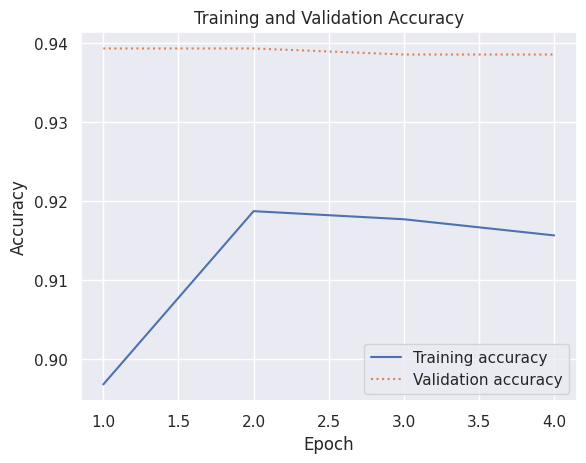

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
def translate_text(text, model, O_tokenizer, T_tokenizer, O_max_len):
    sequence = O_tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=O_max_len, padding='post')
    prediction = model.predict(padded_sequence, verbose=0)[0]
    indexes = [np.argmax(idx) for idx in prediction]
    return T_tokenizer.sequences_to_texts([indexes])[0]

texts = O[4000:4010].values

for text in texts:
    translated = translate_text(text, model, O_tokenizer, T_tokenizer, O_max_len)
    print(f'{text} => {translated}')

thuolo mar telo koloso eyor mbui ekinde dhialo nyasi mar odiochieng jogo ma mine => 
ebuo piny ngima nyasi ma thor mare en thuolo mar mine etelo yudo thuolo marom => 
ekindeni mar corona mikai kenyatta okuayo mine mondo oting duondgi ekedo kod => 
timbe gi kit oganda madhi ataro mar ratich jogo ma mine ka olero ni mwandu => 
mathoth oseket etieko timbe makamago olero ni yiero mar miyo mokuongo kaka => 
jalup jatend piny mar america nyiso ni mine nyalo kendo mine onego oti gi thuolo mag => 
telo magiyudo eberp ngima oganda korka kore jatend migawo mar weche chuech => 
kata gender ngire margret kobia olero ni kata obedo ni duach mine mar yudo telo => 
osebedo gi gode kod orido telo makamano osenyago olemo chanjo apisas mag => 
thieth omedo yudo chanjo ne tuo mar corona kawuono jagoro mongirore e => 


In [ ]:
translate_text('nyalo', model, O_tokenizer, T_tokenizer, O_max_len)

''

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
tf.random.set_seed(42)

# Assuming O_x and T_y are your features and labels respectively
# Ensure correct data preprocessing, including padding and splitting

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(O_x, T_y, test_size=0.3, random_state=42)

# Define the model
model = Sequential()
model.add(Embedding(input_dim=O_vocab_size, output_dim=256, input_length=O_max_len, mask_zero=True))
model.add(LSTM(256))
model.add(RepeatVector(T_max_len))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))  # Increased dropout rate
model.add(TimeDistributed(Dense(T_vocab_size, activation='softmax')))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary(line_length=100)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Fit the model
hist = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])


Model: "sequential_1"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 embedding_1 (Embedding)                     (None, 210, 256)                        2064128        
                                                                                                    
 lstm_2 (LSTM)                               (None, 256)                             525312         
                                                                                                    
 repeat_vector_1 (RepeatVector)              (None, 218, 256)                        0              
                                                                                                    
 lstm_3 (LSTM)                               (None, 218, 256)                        525312         
                                                                     

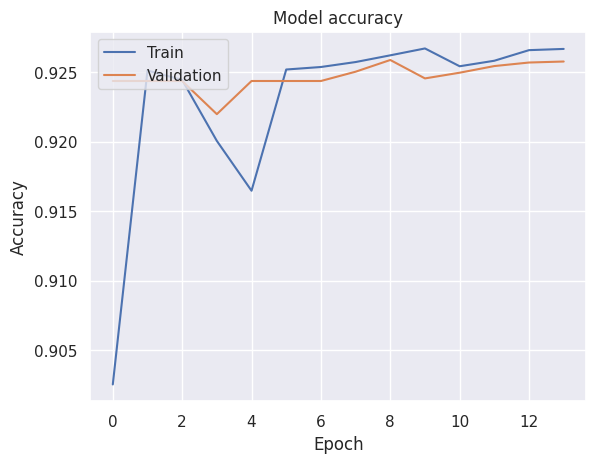

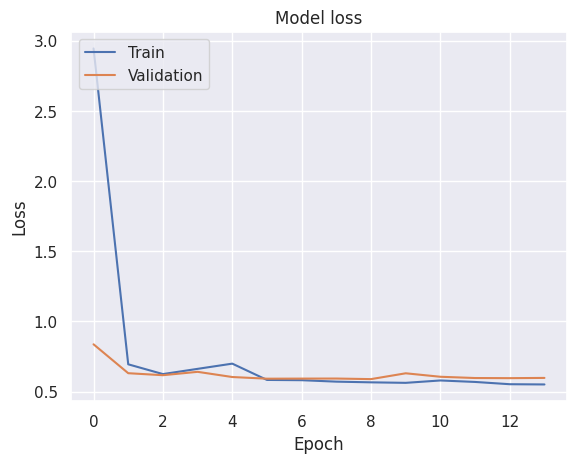

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
def translate_text(text, model, O_tokenizer, T_tokenizer, O_max_len):
    sequence = O_tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=O_max_len, padding='post')
    prediction = model.predict(padded_sequence, verbose=0)[0]
    indexes = [np.argmax(idx) for idx in prediction]
    return T_tokenizer.sequences_to_texts([indexes])[0]

texts = O[400:410].values

for text in texts:
    translated = translate_text(text, model, O_tokenizer, T_tokenizer, O_max_len)
    print(f'{text} => {translated}')

riwruok mar maendeleo ya wanawake ochako chienro mar tingo malo wakeyni kaokadho e pogo gi tangi mag pii e pachoka mangima => wa wa ya ya ya ya ya
jakeno mar riwruogno mikai susan owino olero ni gitiyo gi riwruoge mag mine echopo ir mine gi tangi mag pii => wa wa ya ya ya ya ya
olero ni pii thoro kethore ekinde koth kabang koth to mine wuotho alanda kamanyo pii => wa wa ya ya ya ya
mikai owino olero ni tangi makamago biro konyo mine kano pii eyo makare => wa wa ya ya
koloso ekinde romo gi mine e kisumu county mikai owino olero ni gikonyo mine yudo tangi pii kendo gibiro chulo kaluwore gi kaka giketo winjruok gi beengi => wa wa ya ya ya ya ya ya ya ya ya ya ya
okuayo mine odonj e riwruoge manyalo konyogi yudo ber makamago => wa wa ya ya
jatend piny america moluor joe biden nigi geno ni corona virus dhi rumo epinyno kochopo tarik  dwe mar  higani odiochieng ma america dhiale loch margi kata independence => wa wa ya ya ya ya ya ya ya ya
etuak mare makende ne jopiny america moluor biden ol

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Prepare the input and target texts
input_texts = df['O'].values
target_texts = df['T'].values

# Tokenize the input and target texts
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)

target_tokenizer = Tokenizer()
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)

# Determine the maximum sequence lengths for padding
max_input_length = max(len(seq) for seq in input_sequences)
max_target_length = max(len(seq) for seq in target_sequences)

# Pad the sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_target_length, padding='post')

# Split the data into training and validation sets
input_train, input_val, target_train, target_val = train_test_split(input_sequences, target_sequences, test_size=0.2)

# Get the size of the vocabularies
input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1


In [ ]:
import numpy as np
import pandas as pd
import re
from unicodedata import normalize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
import nltk
nltk.download('punkt')

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Load and preprocess data
df = pd.read_csv("/content/drive/MyDrive/Dholuo-Swahili_cleaned_data.csv")

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

df['source'] = df['O'].apply(clean_text)
df['target'] = df['T'].apply(clean_text)

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

df['source'] = df['source'].apply(clean_text)
df['target'] = df['target'].apply(clean_text)

# Define input and output sequences
source_texts = df['source'].values
target_texts = df['target'].values

# Parameters
source_max_len = max(len(text.split()) for text in source_texts)
target_max_len = max(len(text.split()) for text in target_texts)

# Tokenizers
source_tokenizer = Tokenizer()
source_tokenizer.fit_on_texts(source_texts)
source_sequences = source_tokenizer.texts_to_sequences(source_texts)
source_x = pad_sequences(source_sequences, maxlen=source_max_len, padding='post')

target_tokenizer = Tokenizer()
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)
target_y = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')

source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

print(f'Source vocabulary size: {source_vocab_size}')
print(f'Target vocabulary size: {target_vocab_size}')
print(f'Source max sequence length: {source_max_len}')
print(f'Target max sequence length: {target_max_len}')

# Ensure data types are correct
source_x = np.array(source_x, dtype=np.int32)
target_y = np.array(target_y, dtype=np.int32)

# Model definition
model = Sequential()
model.add(Embedding(input_dim=source_vocab_size, output_dim=256, input_length=source_max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
# model.add(Attention())
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(RepeatVector(target_max_len))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(target_vocab_size, activation='softmax')))

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Reshape targets for sparse_categorical_crossentropy
target_y = np.expand_dims(target_y, -1)  # Shape should be (batch_size, sequence_length, 1)

# Train the model
callback1 = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
callback2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
history = model.fit(source_x, target_y, epochs=20, batch_size=64, validation_split=0.3, callbacks=[callback1, callback2])

# Plot training and validation accuracy and loss
sns.set()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, '-', label='Training Loss')
plt.plot(epochs, val_loss, ':', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Save the trained model
model.save('translation_model.h5')

# Function to translate text
def translate_text(text, model, source_tokenizer, target_tokenizer, source_max_len, target_max_len):
    sequence = source_tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=source_max_len, padding='post')
    prediction = model.predict(padded_sequence, verbose=0)[0]
    indexes = [np.argmax(idx) for idx in prediction]
    translated = ' '.join([target_tokenizer.index_word.get(idx, '') for idx in indexes if idx > 0])
    return translated

# Function to compute BLEU score
def compute_bleu_score(references, candidates):
    references = [[ref.split()] for ref in references]
    candidates = [cand.split() for cand in candidates]
    return corpus_bleu(references, candidates)

# Translate a few sentences and compute BLEU score
texts_to_translate = source_texts[:10]  # Example subset
reference_texts = target_texts[:10]

translated_texts = [translate_text(text, model, source_tokenizer, target_tokenizer, source_max_len, target_max_len) for text in texts_to_translate]

bleu_score = compute_bleu_score(reference_texts, translated_texts)
print(f'BLEU score: {bleu_score}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mounted at /content/drive
Source vocabulary size: 8060
Target vocabulary size: 9693
Source max sequence length: 210
Target max sequence length: 218


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_23 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_24 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_11 (RepeatVector)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_25 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ ?                           │     0 (unbuilt) │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

NameError: name 'ReduceLROnPlateau' is not defined